# Multi-lable classificatin


In [11]:
%matplotlib inline
import math
import os
import data_util
import BMapModel
#from data_util import DataPoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import faiss
# import joblib # version incompatibel with sklearn's joblib and can't load the previous model


from sklearn.externals import joblib # store classifiers
from sklearn.preprocessing import MultiLabelBinarizer # convert y to {0,1}^L
from sklearn.preprocessing import StandardScaler # normalize features 
from sklearn.feature_extraction import DictVectorizer # extract feature vector to x
from numpy.random import normal # generate transforming matrix
from sklearn.neighbors import KDTree #KDTree for fast kNN search
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import average_precision_score
from joblib import Parallel, delayed # Multitread
from pytictoc import TicToc

In [12]:
!ls -R ../data

../data:
AmazonCat  Delicious  Mediamill  README_Datasets  XMLDatasetRead
Bibtex	   Eurlex     RCV1-x	 Wiki10

../data/AmazonCat:
amazonCat_test.txt  amazonCat_train.txt

../data/Bibtex:
Bibtex_data.txt  bibtex_trSplit.txt  bibtex_tstSplit.txt

../data/Delicious:
Delicious_data.txt  delicious_trSplit.txt  delicious_tstSplit.txt

../data/Eurlex:
eurlex_test.txt  eurlex_train.txt

../data/Mediamill:
Mediamill_data.txt  mediamill_trSplit.txt  mediamill_tstSplit.txt

../data/RCV1-x:
rcv1x_test.txt	rcv1x_train.txt

../data/Wiki10:
wiki10_test.txt  wiki10_train.txt

../data/XMLDatasetRead:
XMLDatasetRead

../data/XMLDatasetRead/XMLDatasetRead:
ReadData_Matlab  README_Datasets

../data/XMLDatasetRead/XMLDatasetRead/ReadData_Matlab:
make.m	read_data.cpp  README.txt  write_data.cpp


In [13]:
ls ../data/Delicious/Delicious_data.txt

../data/Delicious/Delicious_data.txt*


In [14]:
data_dir = "../data"
model_dir = "../model/model3"
train_filename = "/Delicious/Delicious_data.txt"
#test_filename = "/Eurlex/eurlex_test.txt"
tr_split_file = "/Delicious/delicious_trSplit.txt"
te_split_file = "/Delicious/delicious_tstSplit.txt"

path = os.path.dirname(train_filename)
model_path = model_dir + path
num_core = 8
L_hat_ratio =1
time = TicToc()

In [15]:
tr_data, num_point, num_feature, num_label = data_util.read_file(data_dir+train_filename)
print("num_point={}, num_label={}, num_feature={}".format(num_point, num_label, num_feature))

num_point=16105, num_label=983, num_feature=500


In [16]:
#te_data, _, _, _ = data_util.read_file(data_dir+test_filename)

In [17]:
tr_split = data_util.split_data(data=tr_data, split_file=data_dir+tr_split_file)
te_split = data_util.split_data(data=tr_data, split_file=data_dir+te_split_file)

In [18]:
X_tr, Y_tr, X_te, Y_te = data_util.data_transform(tr_split, te_split, num_label)

## Binary mapping + BCH + kNN
data set $(x,y)^d$, where $y_i=\{1, 0\}^L$

we want to map y into lower space by $$z = [M\cdot y]$$ where M is a multivariant i,i,d Gaussian matrix, and $[]$ is tkaing the sign.

Then we add redundency to z and get the encoded z' by applying the BCH error correction code. $z' \in \{1,0\}^{redundency*\hat L}$

Then we train binary classifiers on each bit of $z' \in \{0, 1\}^{\hat L}$

For each test point, we predict its $\hat {z'}$ and decode $\hat z$ then use kNN to find the nearest k neighbors from $z=[My]$ which is all our lower degree space's mapping.

### Step 0: data preposseing
normalize features and select prominent features

In [19]:
# normalize features
X_tr = StandardScaler().fit_transform(X_tr)
X_te = StandardScaler().fit_transform(X_te)
X_tr.shape

(12920, 500)

### Step 1: map to $\hat L$ space and construct KD-tree

The apply $$\hat L = k \log L$$ where $k$ indicates the sparsity of each label vector $y_i = \{0,1\}^L$. By default we choose k to be the 99.9% maximum sparsity to avoid extreme cases.

The data in "Eurlex" contains $L = 5000$ labels, we are trying to map it into $\hat L = 200$ space.

In [12]:
k = sorted([Y.sum() for Y in Y_tr], reverse=True)[int(num_point*0.001)]
k

12

In [13]:
np.random.seed(0)
L_hat = int(math.ceil(k * math.log(Y_tr.shape[1], 2) * L_hat_ratio))
M = normal(size=(L_hat, Y_tr.shape[1]))
Z_tr = M.dot(Y_tr.T).T # z = n*\hat L
Z_tr = np.apply_along_axis(lambda x: [0 if elem < 0 else 1 for elem in x], 0, Z_tr) #sign

In [14]:
Z_tr.shape

(15539, 144)

In [29]:
import bchlib

ImportError: ./bchlib.so: undefined symbol: PyUnicode_AsUTF8

(15539, 3993)

### Step 2: Train Model

#### 2.1 train binary classifiers on each bit

In [ ]:
def train_bit(bit):
    print "Trianning model for the {}th bit\n... ... ... \n".format(bit)
    #clf = LogisticRegression(solver='sag')
    clf = LinearSVC(dual=False)
    clf.fit(y=Z_tr[:, bit], X=X_tr)
    joblib.dump(clf, os.path.join(model_path , 'label{}.pkl'.format(bit)))
    print "{}th bit's model successfully stored in {}/label{}.pkl\n".format(bit, model_path, bit)

In [ ]:
from joblib import Parallel, delayed # Multitread
Parallel(n_jobs=num_core)(delayed(train_bit)(i) for i in range(Z_tr.shape[1]))

#### 2.2 Store the lower degree space info for kNN

We use opensource faiss library from FAIR to speedup the ANN(Approximate Nearest Neighbor) search.

When dimension and data size is relatively small, we use the brute force kNN search.

In [16]:
# faiss brute force search
nn_index = faiss.index_factory(Z_tr.shape[1], "Flat", faiss.METRIC_L2)   # build the index
nn_index.add(Z_tr.astype('float32'))

```Python
# index created by index factory
nn_index = faiss.index_factory(Z_tr.shape[1], "IVF100,Flat", faiss.METRIC_L2) # need train
nn_index.train(Z_tr.astype('float32'))
nn_index.add(Z_tr.astype('float32'))

print nn_index.nlist # number of clusters, only INF has this
nn_index.nprobe = 1 # number of clusters to search through, only INF has this, need to be validate
```

### Step 3 Prediction and Validation

In [17]:
model = BMapModel.BM_Predictor(L_hat, nn_index, Y_tr, model_path)

In [18]:
# k=1 without voting
time.tic()
Y_pred = model.vote_y(X_te, 20) # 1 nearest neighbor
time.toc()

Elapsed time is 4.268343 seconds.


In [19]:
average_precision_score(y_true=Y_te, y_score=Y_pred, average='weighted')

/home/horacehxw/anaconda2/lib/python2.7/site-packages/sklearn/metrics/ranking.py:415: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


nan

In [20]:
def precision_at_k(truth, vote, k):
    '''
    evaluate precision at k for a vote vector
    p@k = num of correct prediction in topk / k
    '''
    success = 0
    for i in range(len(truth)):
        # find the k-largest index using partition selet
        # topk are not sorted, np.argsort(vote[topk]) can do that but not needed here
        topk = np.argpartition(vote[i], -k)[-k:] 
        success += np.sum(truth[i, topk])
    return success / ((float(len(truth)))*k)

In [21]:
Y_pred = model.vote_y(X_te, 20)
precision_at_k(Y_te, Y_pred, 1)

0.58624310842740879

#### 3.2 optimize hyperparameter
use  k fold cross validation to optimize over 

In [22]:
from sklearn.model_selection import KFold

In [27]:
def validate(L_hat, pk=1, vote=20): # simple forkable parallel for loop body
    #k_fold = KFold(n_splits=fold)
    print "L_hat is now {}\n".format(L_hat)
    p_sum = 0
   # for train_index, test_index in k_fold.split(X_tr):
    x_train = X_tr
    y_train = Y_tr
    x_test = X_te
    y_test = Y_te

    # map and create kNN index
    np.random.seed(0) # reproduce
    M = normal(size=(L_hat, y_train.shape[1]))
    z_train = M.dot(y_train.T).T # z = n*\hat L
    z_train = np.apply_along_axis(lambda x: [0 if elem < 0 else 1 for elem in x], 0, z_train) #sign
    # faiss brute force search
    knn_index = faiss.index_factory(z_train.shape[1], "Flat", faiss.METRIC_L2)   # build the index
    knn_index.add(z_train.astype('float32'))

    # construct model
    model = BMapModel.BM_Predictor(L_hat, knn_index, y_train, model_path)
    #predict and calculate p@k score
    y_pred = model.vote_y(x_test, vote)
    # precision@pk
    #p_sum += precision_at_k(y_test, y_pred, k=pk)
    return precision_at_k(y_test, y_pred, k=pk)
        

In [34]:
# Optimize L_hat's value on the metric precision@k
pk=1
vote=40
L_hat_range = range(1, 144)

In [35]:
L_hat_score = Parallel(n_jobs=num_core)(delayed(validate)(L_hat, pk, vote) for L_hat in L_hat_range)

L_hat is now 1
L_hat is now 2

L_hat is now 5
L_hat is now 4
L_hat is now 3
L_hat is now 6

L_hat is now 8

L_hat is now 7





L_hat is now 9

L_hat is now 10

L_hat is now 11

L_hat is now 12

L_hat is now 13

L_hat is now 14
L_hat is now 15


L_hat is now 16

L_hat is now 17

L_hat is now 18

L_hat is now 19

L_hat is now 20

L_hat is now 21

L_hat is now 22

L_hat is now 23

L_hat is now 24

L_hat is now 25

L_hat is now 26

L_hat is now 27

L_hat is now 28

L_hat is now 29

L_hat is now 30

L_hat is now 31

L_hat is now 32

L_hat is now 33

L_hat is now 34

L_hat is now 35

L_hat is now 36

L_hat is now 37

L_hat is now 38

L_hat is now 39

L_hat is now 40

L_hat is now 41

L_hat is now 42

L_hat is now 43

L_hat is now 44

L_hat is now 45

L_hat is now 46

L_hat is now 47

L_hat is now 48

L_hat is now 49

L_hat is now 50

L_hat is now 51

L_hat is now 52

L_hat is now 53

L_hat is now 54

L_hat is now 55

L_hat is now 56

L_hat is now 57

L_hat is now 58

L_hat is now 59

L_hat 

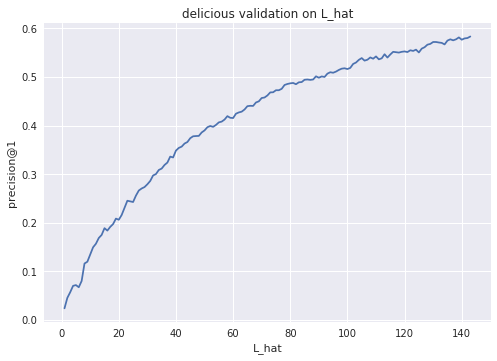

In [37]:
plt.plot(L_hat_range, L_hat_score)
plt.xlabel('L_hat')
plt.ylabel('precision@{}'.format(pk))
plt.title('delicious validation on L_hat')